In [1]:
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
#load image data 
FileDirX= '/content/drive/MyDrive/CS 738/Project/render/*.png'
FileDirY= '/content/drive/MyDrive/CS 738/Project/ground/*.png'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()

#for k in range(0, len(Files_ListY)): # create Xdata and Ydata
#  print(Files_ListX[k], '\n')
#  print(Files_ListY[k], '\n')

## Due to Large Sample Size and High Dimensionality, Create Functions to Make Sure Memory is Freed Up Creating the Batches

In [ ]:
def CreateDataBatchX(FilesListX, FilesListY, StartIndex, StopIndex, batchString):

  Xdata = np.zeros((480,720,3, StopIndex - StartIndex), dtype = np.float32)
  NewXData = FilesListX[StartIndex:StopIndex]
  for i in range(0, len(NewXData)):
    img = plt.imread(NewXData[i]) # get the image
    Xdata[:,:,:,i] = img
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/Xdata_' + batchString, Xdata)
  del Xdata
  gc.collect()

  #Ylabels = np.zeros((480,720,3, StopIndex - StartIndex), dtype = np.float32)  
  #NewYData = FilesListY[StartIndex:StopIndex]
  #for i in range(0, len(NewXData)):
  #  img_label = plt.imread(NewYData[i]) # get the segmentation label
  #  Ylabels[:,:,:,i] = img_label
  #np.save('/content/drive/MyDrive/CS 738/Project/Batched Data/Ylabels_' + batchString, Ylabels)
  #Ylabels = None
  #gc.collect()


In [ ]:
def CreateDataBatchY(FilesListX, FilesListY, StartIndex, StopIndex, batchString):

  #Xdata = np.zeros((480,720,3, StopIndex - StartIndex), dtype = np.float32)
  #NewXData = FilesListX[StartIndex:StopIndex]
  #for i in range(0, len(NewXData)):
  #  img = plt.imread(NewXData[i]) # get the image
  #  Xdata[:,:,:,i] = img
  #np.save('/content/drive/MyDrive/CS 738/Project/Batched Data/Xdata_' + batchString, Xdata)
  #Xdata = None
  #gc.collect()

  Ylabels = np.zeros((480,720,3, StopIndex - StartIndex), dtype = np.float32)
  NewYData = FilesListY[StartIndex:StopIndex]
  for i in range(0, len(NewYData)):
    img_label = plt.imread(NewYData[i]) # get the segmentation label
    Ylabels[:,:,:,i] = img_label
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/Ylabels_' + batchString, Ylabels)
  del Ylabels
  gc.collect()


In [ ]:
Indices = np.floor(np.linspace(0,len(Files_ListX),num=12)).astype(int) # get indices for breaking up data into batches

In [ ]:
for i,k in enumerate(Indices[0:-1]):

  StartIndex = k
  EndIndex = Indices[i+1]
  batchString = str(i)
  CreateDataBatchX(Files_ListX,Files_ListY,StartIndex, EndIndex, batchString)
  CreateDataBatchY(Files_ListX,Files_ListY,StartIndex, EndIndex, batchString)


In [ ]:
print(Indices)

[   0  887 1775 2663 3551 4439 5326 6214 7102 7990 8878 9766]


In [3]:
#FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtrainData/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainData/*.npy'

#Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

#Files_ListX.sort()
Files_ListY.sort()

test = np.load(Files_ListY[0])
print(test.shape)

(480, 720, 3, 887)


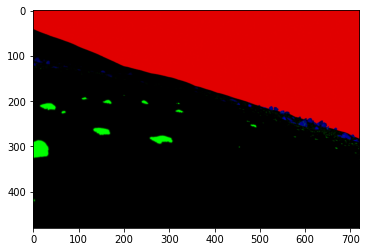

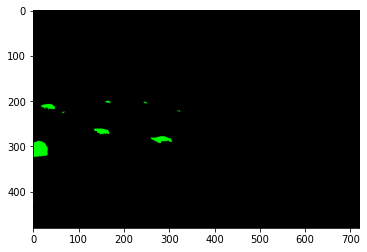

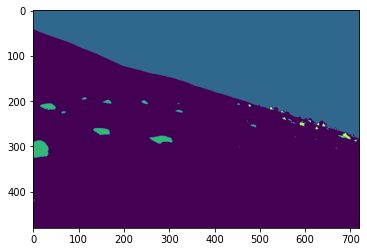

In [116]:
index = np.random.randint(0, test.shape[3])
image = np.copy(test[:,:,:,index])
fig, ax = plt.subplots()
plt.imshow(image)

testImage = image >= 1
fig, ax = plt.subplots()
plt.imshow(testImage.astype(float))

Thresh = 0.5
NewImage = np.copy(image)
NewImage[np.where(image > Thresh)] = 1
NewImage[np.where(image <= Thresh)] = 0

NewImage[:,:,0] = 1*NewImage[:,:,0] 
NewImage[:,:,1] = 2*NewImage[:,:,1] 
NewImage[:,:,2] = 3*NewImage[:,:,2]

Y_1D = np.sum(NewImage, axis=2)
Y_1D = Y_1D.reshape(Y_1D.shape[0], Y_1D.shape[1],1)
Y_1D[np.where(Y_1D > 3)] = 0 

fig, ax = plt.subplots()
plt.imshow(Y_1D[:,:,0])

## Preprocessing Training Data

### Resize Data and Preprocess for Computational Efficiency 

In [ ]:
def normalize(input_image, input_mask):
  #input_image = tf.cast(input_image, tf.float32) / 255.0 # images are already normalized between 0 and 1
  #input_mask -= 1
  input_image = input_image
  return input_image, input_mask

In [ ]:
#@tf.function
def load_image_train(xImage,yImage):
  input_image = tf.image.resize(xImage, (128, 128),method='nearest')
  input_mask = tf.image.resize(yImage, (128, 128),method='nearest')

  #data augmentation
  if tf.random.uniform(()) > 0.5: 
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def KillDistance(Ydata, Thresh):

  # get rid of distance weighting
  Ydata[np.where(Ydata > Thresh)] = 1
  Ydata[np.where(Ydata <= Thresh)] = 0

  return Ydata

In [ ]:
def PreProcessDataTrain(FileX, FileY):

  Xdata = np.load(FileX)
  Ydata = np.load(FileY)

  #Ydata = 

  #initialize new storage array 
  Xtrain = np.zeros((Xdata.shape[3],128,128,3), dtype=np.float32) # the resized dataset
  Ytrain = np.zeros((Xdata.shape[3],128,128,1), dtype=np.float32)  # the resized labels

  for k in range(0, Xtrain.shape[0]):

    Yimage = KillDistance(Ydata[:,:,:,k], 0.5)
    Yimage[:,:,0] = 1*Yimage[:,:,0] 
    Yimage[:,:,1] = 2*Yimage[:,:,1] 
    Yimage[:,:,2] = 3*Yimage[:,:,2]

    #Y_1D = 1*Yimage[:,:,0] + 2*Yimage[:,:,1] + 3*Yimage[:,:,2]
    Y_1D = np.sum(Yimage, axis=2)
    Y_1D = Y_1D.reshape(Y_1D.shape[0], Y_1D.shape[1],1)
    Y_1D[np.where(Y_1D > 3)] = 0 
    
    [x,y] = load_image_train(Xdata[:,:,:,k], Y_1D) # resize and normalize the data
    Xtrain[k,:,:,:] = x
    Ytrain[k,:,:,:] = y
  
  del Xdata
  del Ydata
  gc.collect()

  return Xtrain,Ytrain

In [ ]:
#load image training data
FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtrainData/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainData/*.npy'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()


In [ ]:
for i,k in enumerate(Files_ListX):

  [Xtrain,Ytrain] = PreProcessDataTrain(Files_ListX[i], Files_ListY[i])
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtrainDataResized/Xdata_' + str(i) + '_resized', Xtrain)
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainDataResized/Ylabels_' + str(i) + '_resized', Ytrain)


In [ ]:
#checking some images
#test = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtrainDataResized/Xdata_0_resized.npy')
#test3 = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainData/Ylabels_0.npy')
#test4 = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainDataResized/Ylabels_0_resized.npy')

## Preprocessing Testing Data

In [ ]:
#load image testing data
FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtestData/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtestData/*.npy'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()


In [ ]:
def load_image_test(xImage, yImage):
  input_image = tf.image.resize(xImage, (128, 128),method='nearest')
  input_mask = tf.image.resize(yImage, (128, 128),method='nearest')

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def PreProcessDataTest(FileX, FileY):

  Xdata = np.load(FileX)
  Ydata = np.load(FileY)

  #initialize new storage array 
  Xtest = np.zeros((Xdata.shape[3],128,128,3), dtype=np.float32) # the resized dataset
  Ytest = np.zeros((Xdata.shape[3],128,128,1), dtype=np.float32) # the resized dataset

  for k in range(0, Xtest.shape[0]):

    Yimage = KillDistance(Ydata[:,:,:,k], 0.5)
    
    Yimage[:,:,0] = 1*Yimage[:,:,0] 
    Yimage[:,:,1] = 2*Yimage[:,:,1] 
    Yimage[:,:,2] = 3*Yimage[:,:,2]
    Y_1D = np.sum(Yimage, axis=2)
    Y_1D[np.where(Y_1D > 3)] = 0 
      
    #Y_1D = 1*Yimage[:,:,0] + 2*Yimage[:,:,1] + 3*Yimage[:,:,2]
    #Y_1D = 1*Ydata[:,:,0,k] + 2*Ydata[:,:,1,k] + 3*Ydata[:,:,2,k]
    Y_1D = Y_1D.reshape(Y_1D.shape[0], Y_1D.shape[1],1)
    [x,y] = load_image_test(Xdata[:,:,:,k], Y_1D) # resize and normalize the data
    Xtest[k,:,:,:] = x
    Ytest[k,:,:,:] = y
  
  del Xdata
  del Ydata
  gc.collect()

  return Xtest,Ytest

In [ ]:
for i,k in enumerate(Files_ListX):

  [Xtest,Ytest] = PreProcessDataTest(Files_ListX[i], Files_ListY[i])
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtestDataResized/Xdata_' + str(i+9) + '_resized', Xtest)
  np.save('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtestDataResized/Ylabels_' + str(i+9) + '_resized', Ytest)


(888, 128, 128, 3)
(888, 128, 128, 1)
[0. 1. 2. 3.]


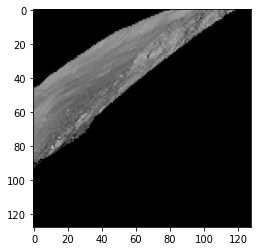

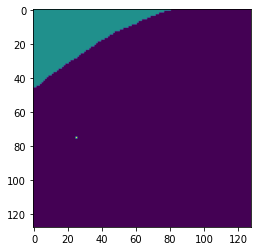

In [ ]:
#checking some images
test = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtestDataResized/Xdata_9_resized.npy')
#test2 = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainData/Ylabels_0.npy')
test3 = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtestDataResized/Ylabels_9_resized.npy')


(888, 128, 128, 3)
(888, 128, 128, 1)
[0. 1. 2. 3.]


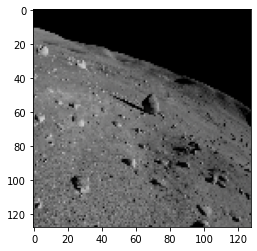

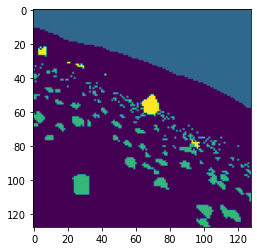

In [ ]:
index = np.random.randint(0, test.shape[0])
fig, ax = plt.subplots()
plt.imshow(test[index])
print(test.shape)
fig, ax = plt.subplots()
plt.imshow(test3[index,:,:,0])
print(test3.shape)
print(np.unique(test3))

In [ ]:
#get statistics for class weighting
from sklearn.utils import class_weight

#load image data 
FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/XtrainDataResized/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data GroundTruth/YtrainDataResized/*.npy'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()


Class0_c = 0
Class1_c = 0
Class2_c = 0
Class3_c = 0
SampleCount = 0

for k in range(0, len(Files_ListY)):
  Ydata = np.load(Files_ListY[k]) # load the class data
  for j in range(0, Ydata.shape[0]):

    Class0_c += np.sum(Ydata[j,:,:,:] ==0)
    Class1_c += np.sum(Ydata[j,:,:,:] ==1)
    Class2_c += np.sum(Ydata[j,:,:,:] ==2)
    Class3_c += np.sum(Ydata[j,:,:,:] ==3)
    SampleCount += (Ydata.shape[1] * Ydata.shape[1])



c0 = np.ones((Class0_c,1))* 0
c1 = np.ones((Class1_c,1))* 1
c2 = np.ones((Class2_c,1))* 2
c3 = np.ones((Class3_c,1))* 3
Y = np.vstack((c0,c1,c2,c3)).astype(int)
Y = Y.reshape(len(Y),)
Yvalues = np.unique(Y)
class_weight = class_weight.compute_class_weight('balanced', Yvalues, Y)
print(class_weight)
print(Class0_c, Class1_c, Class2_c, Class3_c)


[ 0.33933886  1.28443252  5.33767823 11.46896249]
96443538 25479766 6131325 2853531


In [ ]:
whos